In [6]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision import transforms

from google.colab import drive
drive.mount('/content/drive')

class MalariaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

         # Convert image to float32 and add channel dimension
        image = torch.from_numpy(image).type(torch.float32)
        # Add a channel dimension if it's missing
        if image.dim() == 2:  # If image has only height and width
            image = image.unsqueeze(0)  # Add channel dimension at the beginning


        if self.transform:
            image = self.transform(image)

        return image, label

def process_malaria_images(drive_base_path):
    """
    Processes malaria cell images from a directory.

    Args:
        drive_base_path (str): Base path where images are stored.

    Returns:
        tuple: Processed images and their corresponding labels
    """
    parasitized_processed = []
    uninfected_processed = []

    # Paths to image directories
    parasitized_path = os.path.join(drive_base_path, 'Parasitized')
    uninfected_path = os.path.join(drive_base_path, 'Uninfected')

    target_size = (128, 128)

       # Process Parasitized images
    for filename in os.listdir(parasitized_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(parasitized_path, filename)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, target_size)
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            _, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            parasitized_processed.append(img_binary)

    # Process Uninfected images
    for filename in os.listdir(uninfected_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(uninfected_path, filename)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, target_size)
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            _, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            uninfected_processed.append(img_binary)


    # Create labels
    X = parasitized_processed + uninfected_processed
    y = [1] * len(parasitized_processed) + [0] * len(uninfected_processed)

    return X, y

def split_dataset(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Split dataset into train, validation, and test sets.

    Args:
        X (list): Input images
        y (list): Labels
        train_ratio (float): Proportion of training data
        val_ratio (float): Proportion of validation data
        test_ratio (float): Proportion of test data

    Returns:
        tuple: Train, validation, and test sets with their corresponding labels
    """
    # First split off test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    # Calculate validation proportion relative to train_val set
    val_prop = val_ratio / (1 - test_ratio)

    # Split remaining data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_prop, random_state=42, stratify=y_train_val
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Base path to the folder  cell images
drive_base_path = '/content/drive/My Drive/cell_images'

# Procesings images and get dataset
X, y = process_malaria_images(drive_base_path)

# Split dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

# Print dataset sizes
print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.2f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.2f}%)")
print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.2f}%)")

# Create datasets with transforms
#transform = transforms.Compose([
 #   transforms.ToTensor(),
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])

train_dataset = MalariaDataset(X_train, y_train)
val_dataset = MalariaDataset(X_val, y_val)
test_dataset = MalariaDataset(X_test, y_test)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set: 22046 images (80.00%)
Validation set: 2756 images (10.00%)
Test set: 2756 images (10.00%)


**Visualizing the processed images**

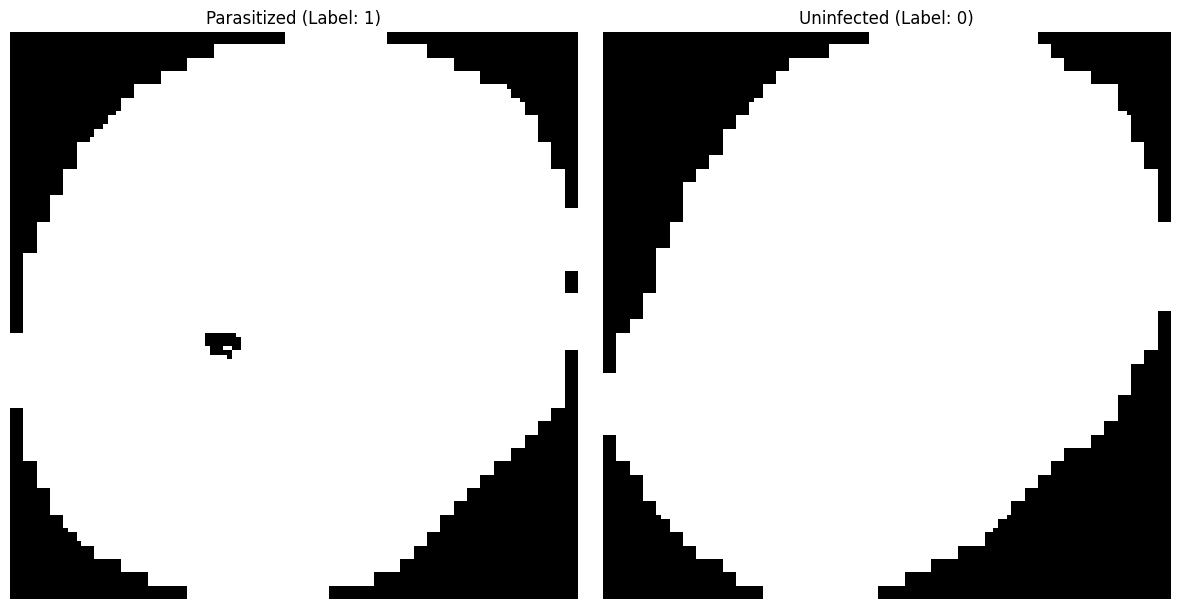

In [7]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision import transforms



def visualize_one_image_per_class(dataset):
    """
    Visualize one image from each class in the dataset


    """
    # Find indices for each class
    parasitized_index = None
    uninfected_index = None

    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == 1 and parasitized_index is None:
            parasitized_index = i
        elif label == 0 and uninfected_index is None:
            uninfected_index = i

        # Stop searching if we've found both
        if parasitized_index is not None and uninfected_index is not None:
            break

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Parasitized image
    image_para, label_para = dataset[parasitized_index]
    if image_para.dim() == 3:  # If image has channel, height, width
        image_para = image_para.squeeze(0).numpy()
    elif image_para.dim() == 2:
        image_para = image_para.numpy()

    # Uninfected image
    image_uninf, label_uninf = dataset[uninfected_index]
    if image_uninf.dim() == 3:  # If image has channel, height, width
        image_uninf = image_uninf.squeeze(0).numpy()
    elif image_uninf.dim() == 2:
        image_uninf = image_uninf.numpy()

    # Plot Parasitized image
    ax1.imshow(image_para, cmap='gray')
    ax1.set_title('Parasitized (Label: 1)', fontsize=12)
    ax1.axis('off')

    # Plot Uninfected image
    ax2.imshow(image_uninf, cmap='gray')
    ax2.set_title('Uninfected (Label: 0)', fontsize=12)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizing one binary image from each class in the training dataset
visualize_one_image_per_class(train_dataset)

 **Feature extraction**

In [8]:

import torch.nn as nn

class MalariaClassifier(nn.Module):
    def __init__(self):
        super(MalariaClassifier, self).__init__()

        self.features = nn.Sequential(  # Extract features using convolutional layers
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Flatten()
        )

        # Calculate the size of the flattened output from the features
        # dummy input with the appropriate shape to get the output size
        dummy_input = torch.randn(1, 3, 128, 128)
        features_output_size = self.features(dummy_input).shape[1]

        self.classifier = nn.Sequential(  # Classify based on extracted features
            nn.Linear(features_output_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2)
        )


    def forward(self, x):
        x = self.features(x) #Extract features
        x = self.classifier(x) #Classify features
        return x

**Early Stopping Utility**

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import copy

class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.best_model = None

    def __call__(self, val_loss, model):
        """
        Check if training should stop


        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """
        Saves model when validation loss decrease.

        Args:
            val_loss (float): Current validation loss
            model (nn.Module): Current model state
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')

        # Deep copy the model
        self.best_model = copy.deepcopy(model)
        self.val_loss_min = val_loss

**Training Functions**

In [10]:


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Track training metrics
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs have the right shape (add channel dimension if needed)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(1)

            # Ensure inputs have 3 channels
            if inputs.size(1) == 1:
                inputs = inputs.repeat(1, 3, 1, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Compute average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Ensure inputs have the right shape (add channel dimension if needed)
                if inputs.dim() == 3:
                    inputs = inputs.unsqueeze(1)

                # Ensure inputs have 3 channels
                if inputs.size(1) == 1:
                    inputs = inputs.repeat(1, 3, 1, 1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        # Compute average validation loss for the epoch
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Current Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\n')

        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Return the best model found during training
    return train_losses, val_losses, early_stopping.best_model

def plot_training_curves(train_losses, val_losses):

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, criterion):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs have the right shape (add channel dimension if needed)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(1)

            # Ensure inputs have 3 channels
            if inputs.size(1) == 1:
                inputs = inputs.repeat(1, 3, 1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total_samples

    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy

**Training setup**

In [11]:

# Instantiate the model
model = MalariaClassifier()

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Create learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',   # Look for minimum validation loss
    factor=0.75,   # Reduce learning rate by 0.75
    patience=1,   # Wait 1 epochs with no improvement
    verbose=True, # Print when learning rate changes
    min_lr=1e-7   # Minimum learning rate
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Training and Evaluation**

In [ ]:

# Train the model
train_losses, val_losses, best_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10  # Increase to allow more room for early stopping
)

# Plot training curves
plot_training_curves(train_losses, val_losses)

# Evaluate on test set using the best model
test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion)

Epoch [1/10]
Training Loss: 0.5191
Validation Loss: 0.4799
Current Learning Rate: 0.000010

Validation loss decreased (inf --> 0.479936).  Saving model ...
Epoch [2/10]
Training Loss: 0.4325
Validation Loss: 0.4301
Current Learning Rate: 0.000010

Validation loss decreased (0.479936 --> 0.430150).  Saving model ...
Epoch [3/10]
Training Loss: 0.3971
Validation Loss: 0.4168
Current Learning Rate: 0.000010

Validation loss decreased (0.430150 --> 0.416764).  Saving model ...
Epoch [4/10]
Training Loss: 0.3741
Validation Loss: 0.4247
Current Learning Rate: 0.000010

EarlyStopping counter: 1 out of 5
